In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [2]:
DATASET_DIRECTORY = 'CICIoT2023MergeData/'

In [3]:
# 获取目录中所有以 .csv 结尾的文件名
df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]

# 初始化一个空列表存储 DataFrame
dataframes = []

# 使用 tqdm 遍历文件列表并读取每个 CSV 文件
for file in tqdm(df_sets, desc="Reading CSV files"):
    filepath = os.path.join(DATASET_DIRECTORY, file)
    # 读取 CSV 文件并将其添加到列表中
    dataframes.append(pd.read_csv(filepath))

# 使用 concat 函数将所有 DataFrame 合并为一个
merged_df = pd.concat(dataframes, ignore_index=True)

Reading CSV files: 100%|█████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.99s/it]


In [4]:
# 打印合并后的 DataFrame 大小
print("Merged DataFrame shape:", merged_df.shape)

Merged DataFrame shape: (2196390, 47)


In [5]:
# 假设你有一个名为merged_df的DataFrame，包含你的所有数据
# X是特征，y是目标变量（如果有的话）
X = merged_df[['flow_duration','Header_Length','ack_flag_number','urg_count','rst_count','Max','AVG','Std','Tot size','Magnitue','Variance']] # 特征
y = merged_df['label']  # 目标变量

In [6]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [7]:
# 按比例（例如80%训练集，20%测试集）分割数据
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 打印训练集和测试集的大小
print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])

Training set size: 1757112
Testing set size: 439278


In [8]:
X_train.shape

(1757112, 11)

In [9]:
# 将输入形状从 (batch_size, 40) 转换为 (batch_size, 11, 1)
input_data_reshape = X_train.reshape((-1, 11, 1))


In [10]:
# 定义模型
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, 3, activation='relu', input_shape=(11, 1)),  # 第一个卷积层，32个3x1的卷积核
    tf.keras.layers.MaxPooling1D(2),  # 最大池化层，池化核大小为2
    tf.keras.layers.Conv1D(64, 3, activation='relu'),  # 第二个卷积层，64个3x1的卷积核
    tf.keras.layers.MaxPooling1D(2),  # 最大池化层
    tf.keras.layers.Flatten(),  # 将特征展平为一维向量
    tf.keras.layers.Dense(128, activation='relu'),  # 全连接层，128个神经元
    tf.keras.layers.Dense(10, activation='softmax')  # 输出层，10个神经元，使用softmax激活函数
])

# 编译模型
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 输出模型结构
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 9, 32)             128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4, 32)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 64)             6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8

In [11]:
model.fit(
    tf.convert_to_tensor(input_data_reshape),
    y_train, 
    epochs=10,
    batch_size = 256
)

Epoch 1/10
6864/6864 [==============================] - 46s 5ms/step - loss: 0.0626 - accuracy: 0.9837
Epoch 2/10
6864/6864 [==============================] - 34s 5ms/step - loss: 0.0432 - accuracy: 0.9884
Epoch 3/10
6864/6864 [==============================] - 36s 5ms/step - loss: 0.0406 - accuracy: 0.9892
Epoch 4/10
6864/6864 [==============================] - 40s 6ms/step - loss: 0.0389 - accuracy: 0.9896
Epoch 5/10
6864/6864 [==============================] - 34s 5ms/step - loss: 0.0377 - accuracy: 0.9899
Epoch 6/10
6864/6864 [==============================] - 36s 5ms/step - loss: 0.0369 - accuracy: 0.9902
Epoch 7/10
6864/6864 [==============================] - 34s 5ms/step - loss: 0.0361 - accuracy: 0.9905
Epoch 8/10
6864/6864 [==============================] - 38s 6ms/step - loss: 0.0354 - accuracy: 0.9907
Epoch 9/10
6864/6864 [==============================] - 44s 6ms/step - loss: 0.0350 - accuracy: 0.9908
Epoch 10/10
6864/6864 [==============================] - 39s 6ms/step - l

In [12]:
# 使用模型进行预测
predictions = model.predict(X_test)
# 获取预测结果中概率最高的类别
predicted_labels = np.argmax(predictions, axis=1)

# 计算模型的准确率

tf.math.confusion_matrix(labels=y_test, predictions=predicted_labels)

13728/13728 [==============================] - 30s 2ms/step
Accuracy: 0.9910626072783066


<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[216106,   3545],
       [   381, 219246]])>

In [13]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
accuracy = np.mean(predicted_labels == y_test)
print("Accuracy:", accuracy)
print('accuracy_score: ', accuracy_score(predicted_labels, y_test))
print('recall_score: ', recall_score(predicted_labels, y_test, average='macro'))
print('precision_score: ', precision_score(predicted_labels, y_test, average='macro'))
print('f1_score: ', f1_score(predicted_labels, y_test, average='macro'))

accuracy_score:  0.9910626072783066
recall_score:  0.9911641526330202
precision_score:  0.9910630007734422
f1_score:  0.9910621505968031


In [14]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('1.png', bbox_inches='tight')

Confusion matrix, without normalization


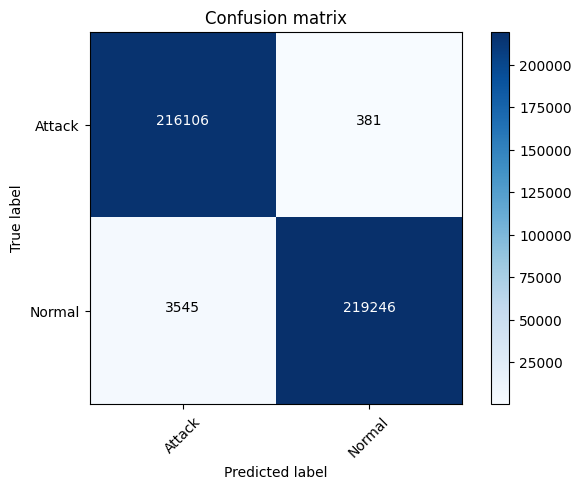

In [15]:
from sklearn import metrics
import itertools
predictions2 = np.argmax(predictions, axis=-1)

cm = metrics.confusion_matrix(predictions2, y_test)
plot_confusion_matrix(cm, classes=['Attack','Normal'])
